In [1]:
import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
import numpy
from sklearn.metrics import accuracy_score

from tslearn.generators import random_walk_blobs
from tslearn.preprocessing import TimeSeriesScalerMinMax, \
    TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries
import pandas as pd
import numpy as np
import random
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesResampler

In [2]:
df = pd.read_pickle("Train.pkl")
randomlist1 = random.sample(range(0, 260), 20)

df_test1 = df.loc[df["Batch"].isin(randomlist1)]
df_train1 = df.loc[~df["Batch"].isin(randomlist1)]
df_steps1 = df_test1.loc[df_test1["CuStepNo ValueY"] != df_test1["Next_Step"]]
df_steps2 = df_train1.loc[df_train1["CuStepNo ValueY"] != df_train1["Next_Step"]]
y_train1 = df_steps2.loc[df_steps2["CuStepNo ValueY"] == 7,"DeviationID ValueY"].astype(int)
y_test1 = df_steps1.loc[df_steps1["CuStepNo ValueY"] == 7,"DeviationID ValueY"].astype(int)
X_train1 = df_train1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_test1 = df_test1.drop(["DeviationID ValueY","Next_Step","timestamp","Unnamed: 0"],axis=1)
X_train_step1 = []
for i in X_train1.Batch.unique():
        num = numpy.array(X_train1.loc[(X_train1["Batch"] == i)&(X_train1["CuStepNo ValueY"] == 7)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_train_step1.append(num)
X_test_step1 = []
for i in X_test1.Batch.unique():
        num = numpy.array(X_test1.loc[(X_test1["Batch"] == i)&(X_test1["CuStepNo ValueY"] == 7)].drop(["Batch","CuStepNo ValueY"],axis=1))
        X_test_step1.append(num)
length = []
for i in X_train_step1:
    length.append(len(i))
X_train_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_train_step1)
X_test_s1 = TimeSeriesResampler(sz=int(np.median(length))).fit_transform(X_test_step1)
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train_s1)
X_test = scaler.transform(X_test_s1)

In [3]:
shp_clf = LearningShapelets(n_shapelets_per_size={23:10},
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=200,
                            weight_regularizer=.01,
                            max_iter=250,
                            random_state=42,
                            scale=True,
                            verbose=0)
shp_clf.fit(X_train, y_train1)

LearningShapelets(batch_size=200, max_iter=250, n_shapelets_per_size={23: 10},
                  optimizer=<keras.optimizers.adam.Adam object at 0x000001FF3D5D5DB0>,
                  random_state=42, scale=True, weight_regularizer=0.01)

In [4]:
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test1, pred_labels))

Correct classification rate: 0.5


In [5]:
shapelets = shp_clf.shapelets_as_time_series_
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)
list1 = []
for i in range(1,24):
    list1.append(i)


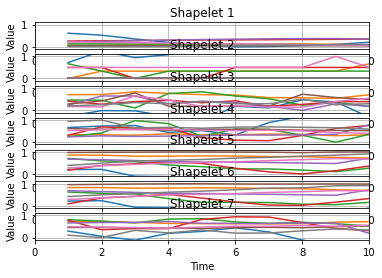

In [6]:
#make subplots
f, ax = plt.subplots(7, 1, sharey="col")
#loop through the shapelets
for i in range(0,7):
    #loop through the classes
    ax[i].plot(list1,shp_clf.shapelets_as_time_series_[0][:,i])
    for j in range(0,7):
        #get the index of the shapelet
        index = np.where(y_train1 == list1[j])
        #get the shapelet
        shapelet = shp_clf.shapelets_as_time_series_[i]
        #plot the shapelet
        ax[i].plot(list1, X_train[j][shp_clf.locate(X_train)[j][0]:shp_clf.locate(X_train)[j][0]+23][:,i])
        ax[i].set_title("Shapelet " + str(i+1))
        ax[i].set_ylabel("Value")
        ax[i].set_xlabel("Time")
        ax[i].set_xlim(0,10)
        ax[i].set_ylim(-0.1,1.1)
        ax[i].grid(True)

plt.show()


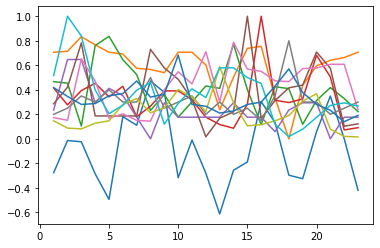

In [7]:

plt.plot(list1,shp_clf.shapelets_as_time_series_[0][:,2])
for i in range(0,10):
    plt.plot(list1, X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2],
)


In [8]:
import plotly.express as px
import plotly.graph_objects as go

# px.line(x=list1,y=shp_clf.shapelets_as_time_series_[0][:,0])
# px.line(x=list1,y=X_train[0][8:15][:,0])
#combine both plotly plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=list1, y=shp_clf.shapelets_as_time_series_[0][:,2],
                    mode='lines',
                    name='Deviation1'))
for i in range(0,10):
    fig.add_trace(go.Scatter(x=list1, y=X_train[i][shp_clf.locate(X_train)[i][0]:shp_clf.locate(X_train)[i][0]+23][:,2],
                        mode='lines',
                        name=f'Time Series {int(y_train1[i:i+1])}'))
fig.update_layout(title='Shapelet nr. 1',
                     xaxis_title='Time',
                        yaxis_title='Value')